[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Entrenamiento de una YOLOv11 sobre un corpus propio

---

YOLO11 se basa en los avances introducidos en YOLOv9 y YOLOv10 a principios de este año, incorporando diseños arquitectónicos mejorados, técnicas de extracción de características optimizadas y métodos de entrenamiento perfeccionados.

YOLO11m logra una puntuación mAP media más alta en el conjunto de datos COCO utilizando un 22% menos de parámetros que YOLOv8m, lo que lo hace computacionalmente más ligero sin sacrificar rendimiento.

YOLOv11 está disponible en 5 tamaños diferentes, desde `2.6M` a `56.9M` de parámetros, siendo capaz de obtener desde `39.5` a `54.7` de mAP sobre el dataset COCO.

Revisamos la GPU a la que nos conectamos (si no aparece ninguna, cambiar la máquina virtual del 'Entorno de ejecución')

In [1]:
!nvidia-smi

Sun Nov 23 19:32:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Instalación de YOLO11 desde Ultralytics

In [3]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.1/112.6 GB disk)


## Uso out-of-the-box

Vamos a usar el modelo más pequeño para hacer inferencia y que nos dé todas las detecciones de las clases que ya tiene pre-entrenadas (dataset COCO).

Debemos subir una imagen cualquiera a la carpeta raíz y ponerle de nombre 'imagen.jpg'

In [5]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='/content/plaza1.jpg' save=True

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/plaza1.jpg: 448x640 10 persons, 4 bicycles, 1 bottle, 50.7ms
Speed: 5.7ms preprocess, 50.7ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


El resultado queda en la carpeta /runs/detect/predict, que va agregando números al final cada vez que hacemos una nueva inferencia, ej: /predict1, /predict2, etc., de manera de no perder los resultados previos.

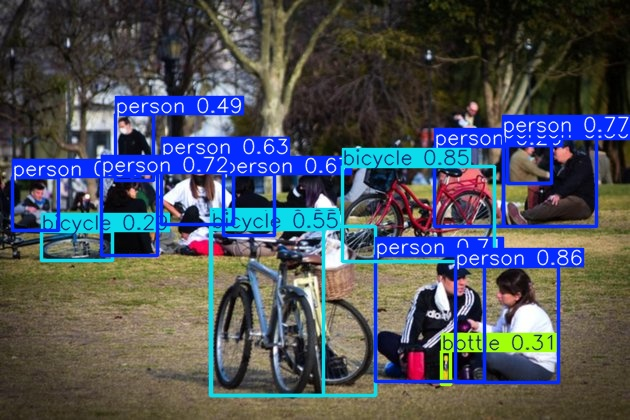

In [6]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/plaza1.jpg', width=600)

**Sobre una imagen de un mate**

Queremos ver ahora cómo se comporta en la detección de un mate (clase no presente en el dataset COCO!)

In [7]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='/content/matetest1.jpg' save=True

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/matetest1.jpg: 416x640 1 person, 1 cup, 1 vase, 49.1ms
Speed: 3.3ms preprocess, 49.1ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)
Results saved to /content/runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


(ACORDARSE! revisar en el log de la inferencia en qué carpeta guardó el resultado, para actualizar la línea siguiente)

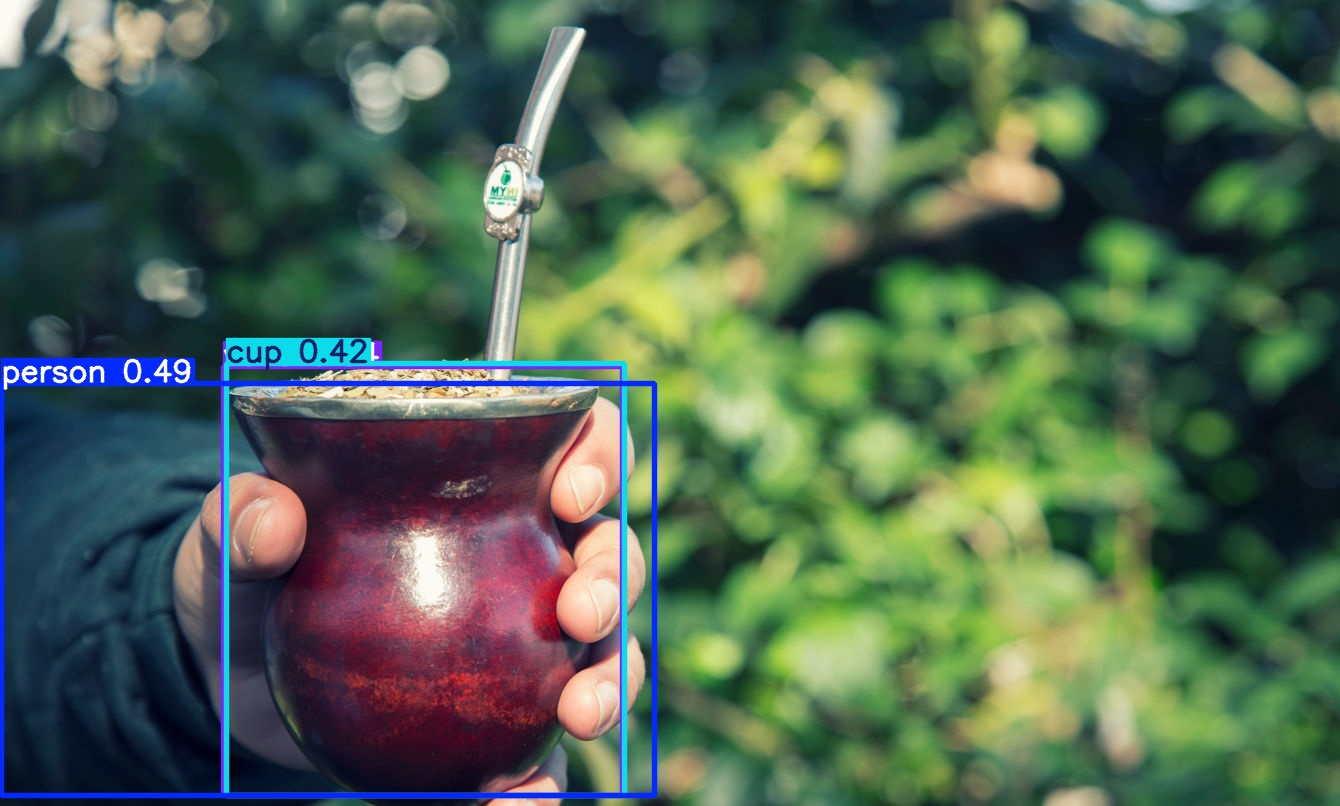

In [8]:
IPyImage(filename=f'{HOME}/runs/detect/predict2/matetest1.jpg', width=600)

## Fine-tuning de una YOLO11 nano sobre el dataset propio

Importamos ahora el dataset generado en Roboflow con las imágenes de mates y con la única clase a detectar 'mate'

In [12]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="S0jzaFciU6OgLxVGCBLO")
project = rf.workspace("aprendizajeautomticoii").project("detector-de-empanadas-fnzno")
version = project.version(2)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Detector-de-empanadas-2 in yolov11:: 100%|██████████| 59/59 [00:00<00:00, 7394.05it/s]


## Re-entrenamiento

In [13]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 plots=True

/content
Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Detector-de-empanadas-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective

Resultados del entrenamiento (con gráficas de desempeño) en `{HOME}/runs/detect/train/`, vamos a examinarlas.

In [14]:
!ls {HOME}/runs/detect/train/

args.yaml			 labels.jpg	     train_batch1.jpg
BoxF1_curve.png			 results.csv	     train_batch2.jpg
BoxP_curve.png			 results.png	     val_batch0_labels.jpg
BoxPR_curve.png			 train_batch0.jpg    val_batch0_pred.jpg
BoxR_curve.png			 train_batch180.jpg  weights
confusion_matrix_normalized.png  train_batch181.jpg
confusion_matrix.png		 train_batch182.jpg


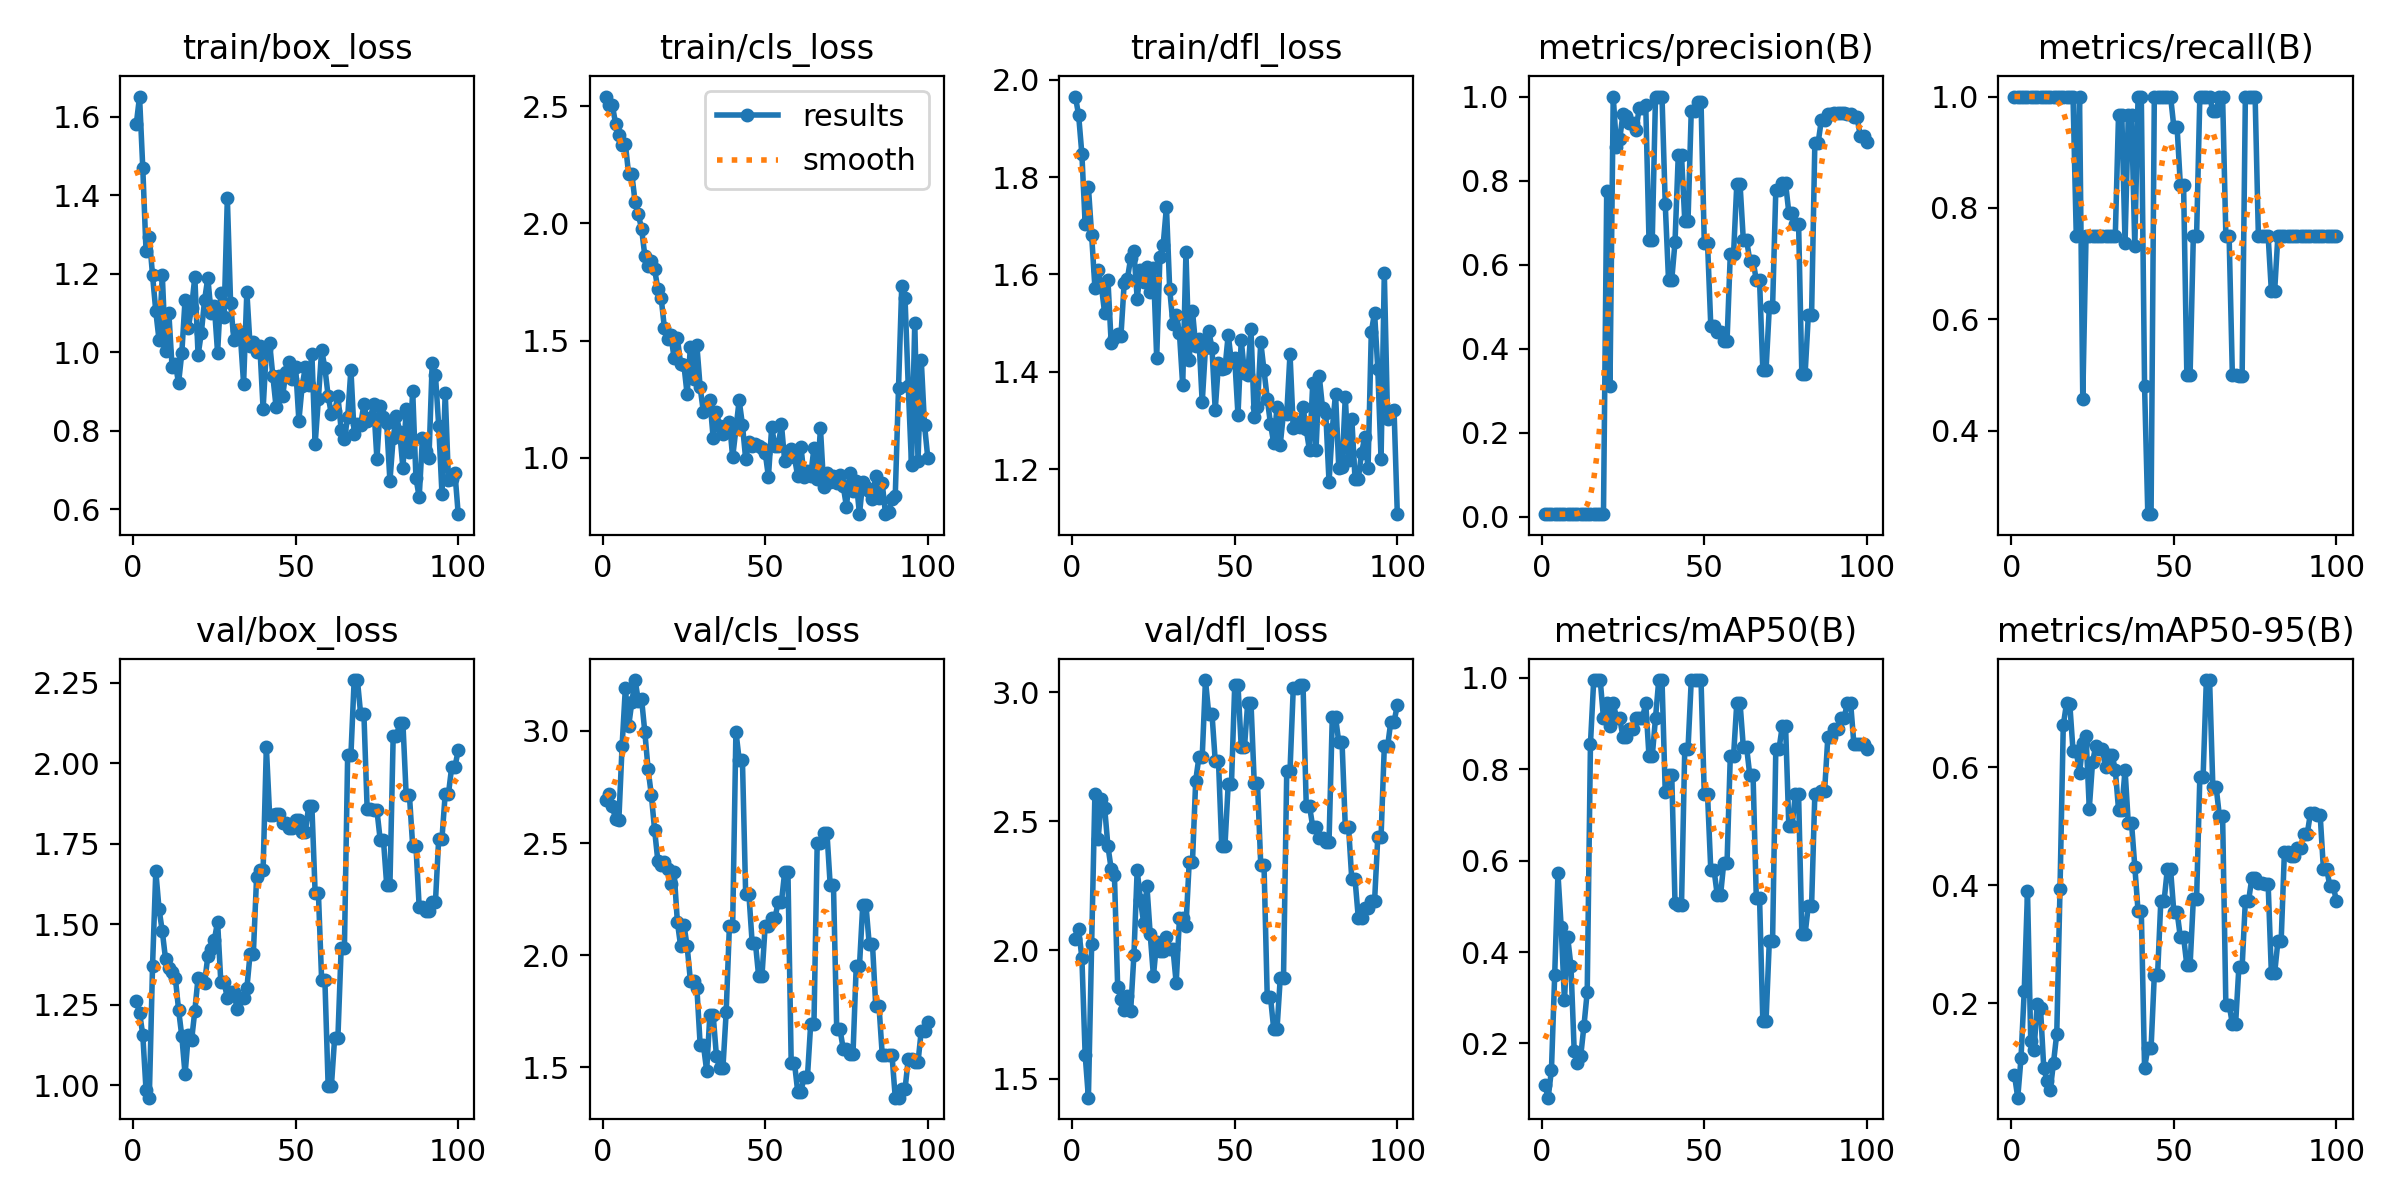

In [15]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

Vemos ahora la detección sobre las imágenes de validación.

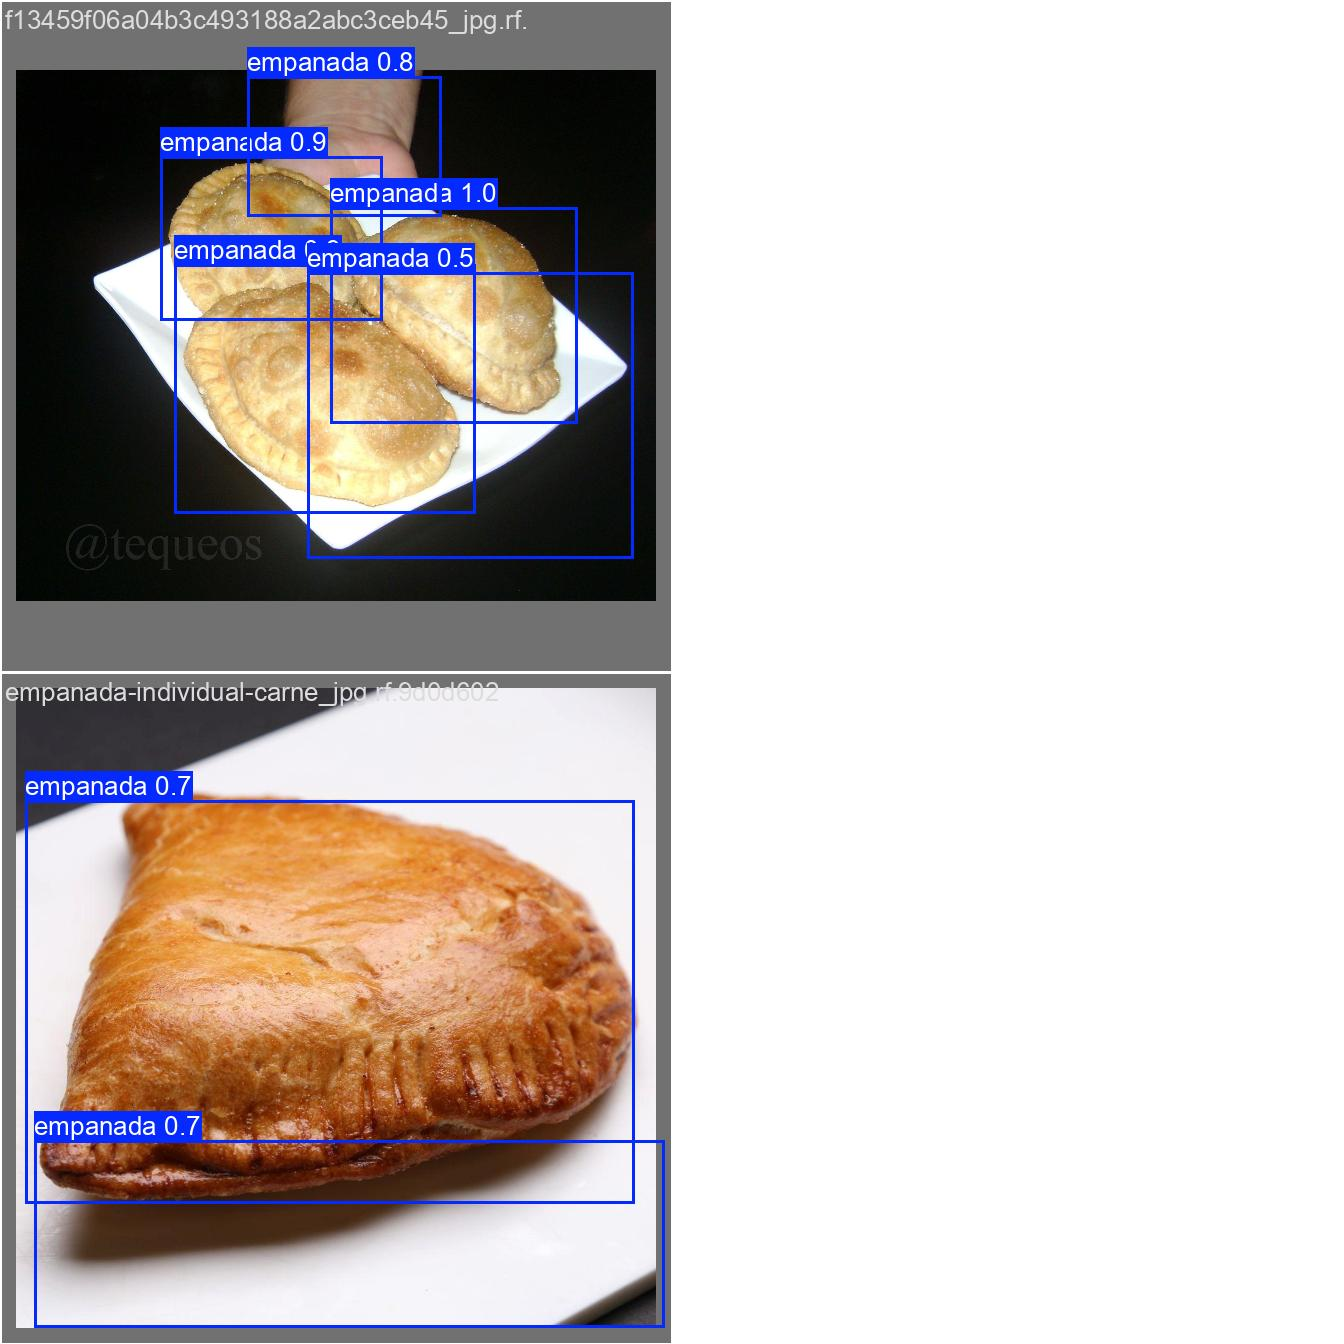

In [16]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Inferencia sobre imágenes de test

Corremos ahora la detección sobre las imágenes de test (no vistas en el entrenamiento)

In [17]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.2 source={dataset.location}/test/images save=True

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /content/Detector-de-empanadas-2/test/images/images_jpg.rf.fb5285cad39616bd26259e5422c16e99.jpg: 640x640 3 empanadas, 18.1ms
Speed: 6.1ms preprocess, 18.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


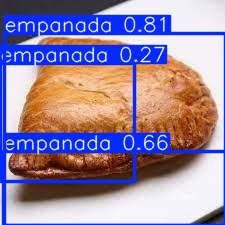

In [18]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict3/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Imagen adicional para prueba

Bajar una imagen nueva y subirla al directorio raíz, luego hacer inferencia y mostrar resultados.

En el código, cambiar la imagen en la variable **source**

ACORDARSE!: si se hicieron varios entrenamientos, los pesos van quedando en carpetas con numeración sucesiva /train1, /train2, etc., revisar que se esté usando la última carpeta entrenada en la variable **model**.

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /content/prueba.jpg: 384x640 6 empanadas, 53.7ms
Speed: 2.4ms preprocess, 53.7ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predict6
💡 Learn more at https://docs.ultralytics.com/modes/predict
Results saved to: /content/runs/detect/predict6/


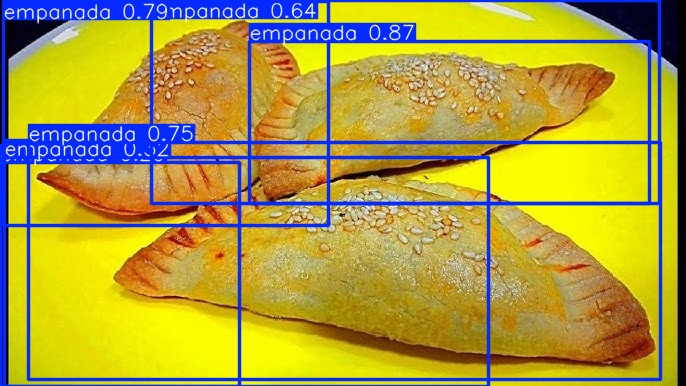

In [21]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=/content/prueba.jpg save=True

latest_predict_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
print(f"Results saved to: {latest_predict_folder}")
# Display the results
from IPython.display import Image as IPyImage, display
for img in glob.glob(f'{latest_predict_folder}/*.jpg'):
    display(IPyImage(filename=img, width=600))
    print("\n")

In [22]:
# prompt: exportar el modelo generado en un formato preparado para luego hacer inferencia con código python local

import os

# Specify the path to the trained model weights
model_path = os.path.join(HOME, "runs/detect/train/weights/best.pt")

# Export the model to ONNX format (or other desired format)
!yolo export model={model_path} format=onnx
# Or for other formats like TorchScript:
#!yolo export model={model_path} format=torchscript

# Optionally, you can specify the output path for the exported model
# !yolo export model={model_path} format=onnx opset=12 imgsz=640 --dynamic

print(f"Exported model saved to: {os.path.dirname(model_path)}")

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 127ms
Prepared 6 packages in 1.69s
Installed 6 packages in 377ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime==1.24.0.dev20251031003
 + onnxslim==0.1.75

requirements: AutoUpdate success ✅ 2.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX:

### Carga del modelo

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
from ultralytics import YOLO

# Load the pre-trained YOLOv11 model from Google Drive
modelo = YOLO('/content/runs/detect/train/weights/best.pt')


image 1/1 /content/test2.jpg: 640x640 3 empanadas, 11.5ms
Speed: 4.0ms preprocess, 11.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict7
Boxes: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0.], device='cuda:0')
conf: tensor([0.6064, 0.4859, 0.2588], device='cuda:0')
data: tensor([[  0.0000,  30.3423, 158.5682, 200.0000,   0.6064,   0.0000],
        [  0.4481,  97.0578, 135.7794, 198.6758,   0.4859,   0.0000],
        [  1.3972, 122.7978, 157.2101, 199.7678,   0.2588,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (200, 200)
shape: torch.Size([3, 6])
xywh: tensor([[ 79.2841, 115.1711, 158.5682, 169.6577],
        [ 68.1138, 147.8668, 135.3313, 101.6180],
        [ 79.3036, 161.2828, 155.8129,  76.9701]], device='cuda:0')
xywhn: tensor([[0.3964, 0.5759, 0.7928, 0.8483],
        [0.3406, 0.7393, 0.6767, 0.5081],
        [0.3965, 0.8064, 0.7791, 0.3849]], device='cuda:0')


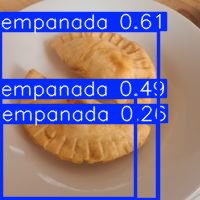

In [28]:
# Assuming you have an image you want to test, for example 'test_image.jpg'
# You can use the predict method of the YOLO model object

results = modelo.predict(source='/content/test2.jpg', save=True, conf=0.25)

# The results object contains the detection results
# You can access information like bounding boxes, class labels, and confidence scores

# To display the results, you can iterate through them
for r in results:
    # r.boxes contains the bounding boxes
    # r.probs contains the classification probabilities (for classification tasks)
    # r.masks contains the segmentation masks (for segmentation tasks)
    # r.keypoints contains the keypoints (for pose estimation tasks)
    print(f"Boxes: {r.boxes}")
    # You can also visualize the results
    r.show() # This will display the image with detections

# The predicted image with bounding boxes is saved to a 'runs/detect/predict' directory by default.
# You can display the saved image as shown in previous cells.